# Italian Airports Network - Performance Analysis since 2000  
  
  <br/><br/>

![](images/00_cover.gif?raw=true)

## 01. Exploratory Data Analysis  
  
  <br/><br/>

This is a personal project that aims to analyze the performance of Italian airports in terms of key operational metrics: aircraft movements, passenger traffic, and freight throughput.  
By examining historical data (starting from the year 2000) and identifying trends, my goal is to gain insights into the efficiency, capacity, and potential areas for improvement of different airports.  
  
  The primary data sources for this analysis is [Assaeroporti](https://assaeroporti.com/), the association of Italian airport operators, which collect historical records on aircraft movements, passenger numbers, and freight tonnage.  
  
  After the data collection, I collated and cleaned the different datasets before enriching them with the IATA code and the geographic area for each airport.  
Before performing EDA, there are other potential features that can be added to the dataset:
- geographic coordinates
- potential catchment area (30 minutes, 60 minutes distance)
- distance from closest motorway exit
- distance from closest railway station
- dimensional class
  
  <br/><br/>
  

## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import warnings
import glob
import os

from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import re

from time import time, sleep

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set(font_scale=0.8)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# run to avoid warnings
warnings.filterwarnings('ignore')

## Data Loading

In [4]:
# load the data from the final CSV
df = pd.read_csv('datasets/final/df_fin.csv')

In [5]:
df

,Airport,Code,Geographic Area,Month,Year,MOV - Domestic,MOV - International,MOV - EU,MOV - General Avio,PAX - Domestic,PAX - International,PAX - EU,PAX - Transit,PAX - General Avio,FRE - Goods Avio,FRE - Goods Ground,FRE - Mail
0,Alghero,AHO,Islands,1,2000,515.0,25.0,0.0,0.0,30634.0,799.0,0.0,0.0,0.0,59.000,0.0000,74.000
1,Ancona,AOI,Central-East,1,2000,476.0,346.0,182.0,574.0,18183.0,12098.0,7056.0,61.0,656.0,232.000,2.0000,68.000
2,Bari,BRI,South,1,2000,1437.0,77.0,0.0,355.0,82936.0,1217.0,0.0,68.0,110.0,168.000,0.0000,193.000
3,Bergamo,BGY,North-West,1,2000,770.0,2302.0,1543.0,216.0,38403.0,48697.0,25666.0,653.0,189.0,7139.000,80.0000,1.000
4,Bologna,BLQ,North-East,1,2000,1379.0,3108.0,2576.0,239.0,67923.0,150338.0,120214.0,5424.0,307.0,945.000,422.0000,255.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,Trapani,TPS,Islands,8,2024,635.0,308.0,270.0,116.0,90896.0,53226.0,46540.0,125.0,181.0,0.000,0.0000,0.000
10993,Treviso,TSF,North-East,8,2024,58.0,1610.0,1275.0,270.0,8858.0,286104.0,227946.0,180.0,281.0,0.000,0.0000,0.000
10994,Trieste,TRS,North-East,8,2024,556.0,446.0,381.0,193.0,68278.0,64413.0,53494.0,24.0,206.0,6.249,0.2630,0.000
10995,Venezia,VCE,North-East,8,2024,1500.0,6493.0,4496.0,642.0,230856.0,974277.0,610136.0,1199.0,1379.0,4527.423,564.7301,0.091


All monthly datasets are downloaded from the website, except for June 2001 which is not available.  
I collected almost 300 Excel files, each one including 8 worksheets for the main operational metrics.  
After checking some Excel files from different years, I can define exactly which column to extract and in which worksheet: fortunately these fields are consistent across the entire file collection, so I can automate the process.  
  
  <br/><br/>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10997 entries, 0 to 10996
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Airport              10997 non-null  object 
 1   Code                 10997 non-null  object 
 2   Geographic Area      10997 non-null  object 
 3   Month                10997 non-null  int64  
 4   Year                 10997 non-null  int64  
 5   MOV - Domestic       10953 non-null  float64
 6   MOV - International  10953 non-null  float64
 7   MOV - EU             10917 non-null  float64
 8   MOV - General Avio   10953 non-null  float64
 9   PAX - Domestic       10953 non-null  float64
 10  PAX - International  10953 non-null  float64
 11  PAX - EU             10917 non-null  float64
 12  PAX - Transit        10953 non-null  float64
 13  PAX - General Avio   10953 non-null  float64
 14  FRE - Goods Avio     10950 non-null  float64
 15  FRE - Goods Ground   9421 non-null  

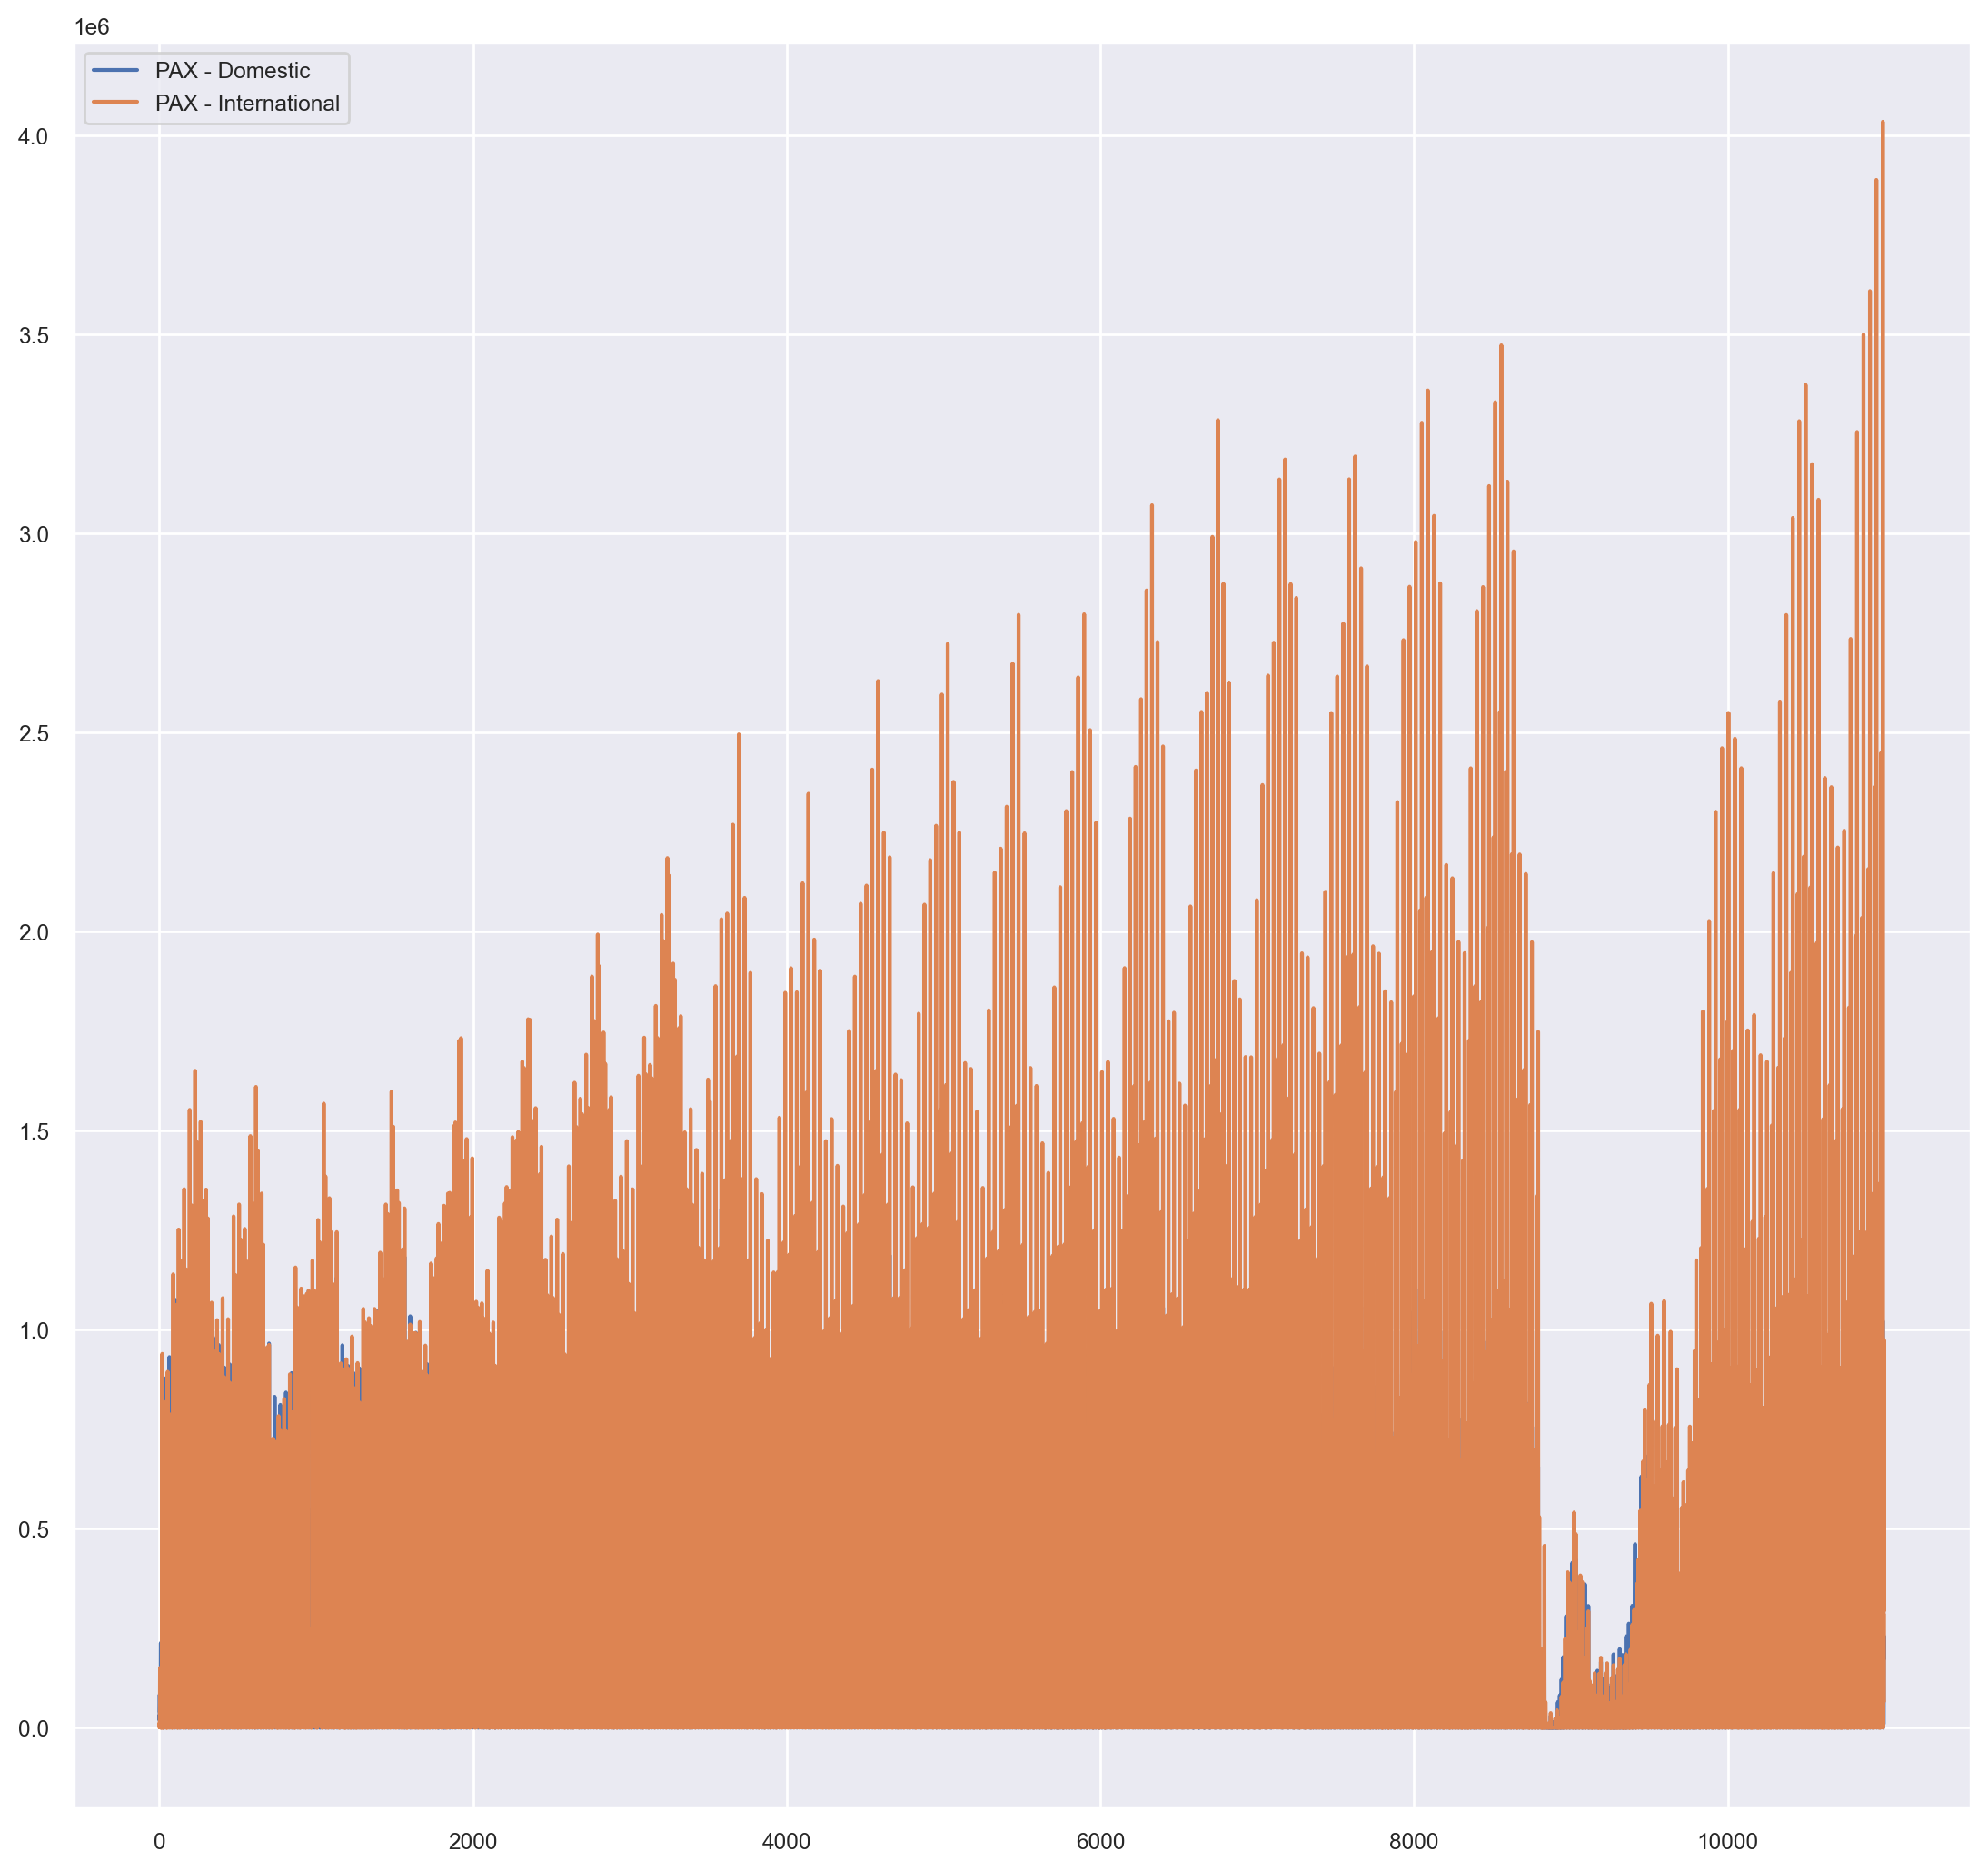

In [7]:

df.plot(y = ['PAX - Domestic', 'PAX - International'],
        figsize=(12, 12), linewidth=1.5);

In [ ]:
# plot the job titles distribution
fig, ax = plt.subplots(figsize = (12,6))

plt.xticks(rotation = 90)
sns.lineplot(x = most_common_jt.index, y = most_common_jt.values, ax=ax)
ax.set_title('Job Title Distribution', loc='left', fontsize=18)
ax.set_xlabel('Job Title', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()